<a href="https://www.kaggle.com/code/aabdollahii/bioseqclassifier?scriptVersionId=253516490" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dna-classification-dataset/synthetic_dna_dataset.csv


# Workflow
* 🕵️ Dataset/goal understanding
* 🎨 EDA (distributions, sequence stats, visualizations)
* 🛠️ Sequence feature extraction (k-mers, etc.)
* 💻 Baseline models (logistic, RF, SVM)
* 🤖 Deep learning models (LSTM, CNN, Transformer)
* 🧬 Mutation/disease analysis (if available)
* 📊 Interpret results (feature/sequence motifs, model explanations)
* 📝 Write-up/report (with pretty plots!)




# Reading File

In [2]:
import numpy as np 
import pandas as pd

df = pd.read_csv("/kaggle/input/dna-classification-dataset/synthetic_dna_dataset.csv")

# Understanding About Data

In [3]:
df.columns

Index(['Sample_ID', 'Sequence', 'GC_Content', 'AT_Content', 'Sequence_Length',
       'Num_A', 'Num_T', 'Num_C', 'Num_G', 'kmer_3_freq', 'Mutation_Flag',
       'Class_Label', 'Disease_Risk'],
      dtype='object')

In [4]:
df.describe()

,GC_Content,AT_Content,Sequence_Length,Num_A,Num_T,Num_C,Num_G,kmer_3_freq,Mutation_Flag
count,3000.000000,3000.000000,3000.0,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,50.120000,49.880000,100.0,24.950667,24.929333,25.004000,25.116000,0.547738,0.496667
std,5.062688,5.062688,0.0,4.317458,4.317702,4.349056,4.329603,0.258521,0.500072
min,34.000000,34.000000,100.0,11.000000,9.000000,10.000000,12.000000,0.100000,0.000000
25%,47.000000,47.000000,100.0,22.000000,22.000000,22.000000,22.000000,0.330000,0.000000
50%,50.000000,50.000000,100.0,25.000000,25.000000,25.000000,25.000000,0.543000,0.000000
75%,53.000000,53.000000,100.0,28.000000,28.000000,28.000000,28.000000,0.772250,1.000000
max,66.000000,66.000000,100.0,40.000000,42.000000,42.000000,42.000000,1.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Sample_ID        3000 non-null   object 
 1   Sequence         3000 non-null   object 
 2   GC_Content       3000 non-null   float64
 3   AT_Content       3000 non-null   float64
 4   Sequence_Length  3000 non-null   int64  
 5   Num_A            3000 non-null   int64  
 6   Num_T            3000 non-null   int64  
 7   Num_C            3000 non-null   int64  
 8   Num_G            3000 non-null   int64  
 9   kmer_3_freq      3000 non-null   float64
 10  Mutation_Flag    3000 non-null   int64  
 11  Class_Label      3000 non-null   object 
 12  Disease_Risk     3000 non-null   object 
dtypes: float64(3), int64(6), object(4)
memory usage: 304.8+ KB


In [6]:
df.shape

(3000, 13)

In [7]:
df.head(10)

,Sample_ID,Sequence,GC_Content,AT_Content,Sequence_Length,Num_A,Num_T,Num_C,Num_G,kmer_3_freq,Mutation_Flag,Class_Label,Disease_Risk
0,SAMPLE_1,CTTTCGGGATACTTTTGGGATGGTCTTGGTCAAGGGTTTTAGCCCG...,50.0,50.0,100,22,28,19,31,0.986,0,Bacteria,High
1,SAMPLE_2,TTGACCAAATTTGATTGGAAGTGGTAAGCGCGTATTCCTAGCATCA...,45.0,55.0,100,27,28,22,23,0.486,1,Virus,Medium
2,SAMPLE_3,GCGTGAGTTCTAATTTAAAAAGTCGTAACACGTACCCCGGCGTGTA...,51.0,49.0,100,26,23,30,21,0.367,1,Bacteria,Low
3,SAMPLE_4,ACTACGCGGACAAGAACCAACAGAACCTGGTTTTCGCAAGGGAGTG...,55.0,45.0,100,28,17,23,32,0.404,0,Human,Medium
4,SAMPLE_5,TTCAATGCAGATTGAAAGTTACTTTCATCTGCCCTATGGGTCCCTT...,46.0,54.0,100,24,30,25,21,0.818,0,Human,High
5,SAMPLE_6,GCGGCTTGTTATCCTGGCAACGCGTTCAACGTCTCAGCACAGTAAC...,45.0,55.0,100,29,26,26,19,0.495,1,Plant,Low
6,SAMPLE_7,ACGTTGACGTAAGCACTCCTCAATGCACCCCTGCCTTCGCCCTTTC...,62.0,38.0,100,12,26,35,27,0.570,1,Bacteria,High
7,SAMPLE_8,ACCGTCCAGAACTAACAAACCGGTGACGAATTGTCGTCATGTCTCT...,46.0,54.0,100,26,28,23,23,0.420,0,Virus,Low
8,SAMPLE_9,GATTAATGACGCCAATTCTCGGGTCCCATAATTCTCGTAAATAAAA...,42.0,58.0,100,32,26,19,23,0.935,1,Human,Low
9,SAMPLE_10,GCCCCTGGTCACGCTGTGTACAGCAGCGGACGTTTAACCGCAGCAG...,59.0,41.0,100,18,23,31,28,0.606,1,Bacteria,Low


* Our primary target is **Class_Label**
* We can also work on **Disease_Risk**
## Biological Relevance & Insights
* Sequence Patterns:The raw Sequence and k-mer features are the “fingerprints” of species identity—certain triplets (k-mers) or GC/AT content are often distinctive across organisms.
* Mutation Analysis
* Composite Features:Redundant columns (Num_A/Num_T/Num_C/Num_G add up to length) are sometimes useful for interpretability and verifying sequence integrity.
-----------------------------------------------------------------------------------------------------
* This dataset provides labeled DNA sequences along with biologically relevant features such as nucleotide composition, GC/AT content, triplet (k-mer) frequency, and mutation/disease annotations. The primary task is to build a classifier to predict the species (Class_Label) from sequence-derived features, with optional auxiliary analyses of mutation prevalence and disease risk.

* The dataset reflects real bioinformatics analysis pipelines, where differentiating DNA based on subtle sequence variations is vital for taxonomy, disease research, and evolutionary studies.




# EDA

In [8]:
df.describe()

,GC_Content,AT_Content,Sequence_Length,Num_A,Num_T,Num_C,Num_G,kmer_3_freq,Mutation_Flag
count,3000.000000,3000.000000,3000.0,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,50.120000,49.880000,100.0,24.950667,24.929333,25.004000,25.116000,0.547738,0.496667
std,5.062688,5.062688,0.0,4.317458,4.317702,4.349056,4.329603,0.258521,0.500072
min,34.000000,34.000000,100.0,11.000000,9.000000,10.000000,12.000000,0.100000,0.000000
25%,47.000000,47.000000,100.0,22.000000,22.000000,22.000000,22.000000,0.330000,0.000000
50%,50.000000,50.000000,100.0,25.000000,25.000000,25.000000,25.000000,0.543000,0.000000
75%,53.000000,53.000000,100.0,28.000000,28.000000,28.000000,28.000000,0.772250,1.000000
max,66.000000,66.000000,100.0,40.000000,42.000000,42.000000,42.000000,1.000000,1.000000


* Good feature variability: All features have meaningful spread, especially base content and 3-mer frequency.
* Sequence length is fixed: Removes length as a confounder.
* Balanced mutation presence: Great for comparing disease vs. non-disease groups.
* Nucleotide composition varies: Some sequences skewed toward higher/lower content of A/T or G/C—important for downstream model learning & interpretation!


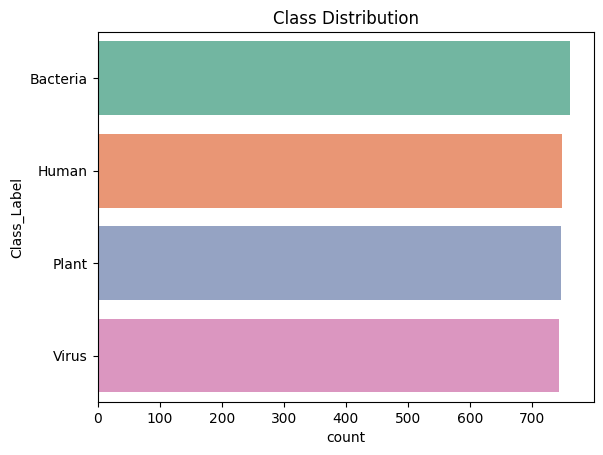

In [9]:
#Class_Label Distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(y='Class_Label', data=df, order=df['Class_Label'].value_counts().index, palette='Set2')
plt.title("Class Distribution")
plt.show()


* This is a well-balanced dataset that helps ML algorithms like RF work properly.
* Possible caution: The real-world dataset is not like that. For real-world deployment, we have rebalanced it

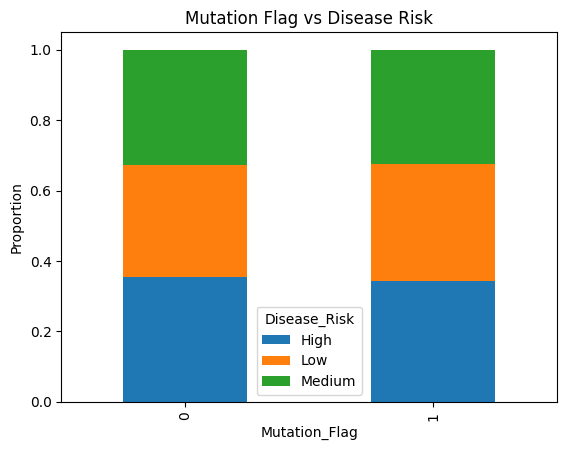

In [10]:
pd.crosstab(df['Mutation_Flag'], df['Disease_Risk'], normalize='index').plot(kind='bar', stacked=True)
plt.title("Mutation Flag vs Disease Risk")
plt.ylabel("Proportion")
plt.show()


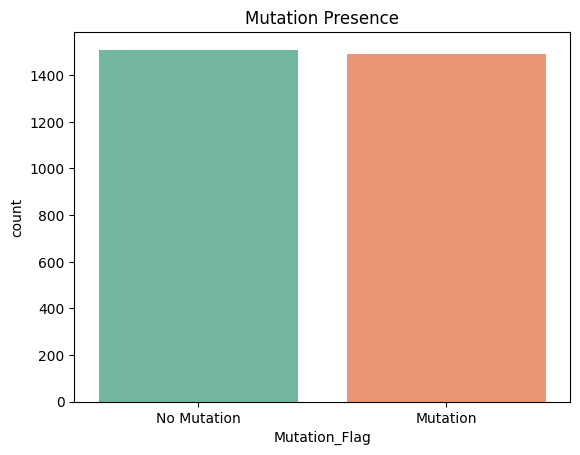

In [11]:
sns.countplot(x='Mutation_Flag', data=df, palette='Set2')
plt.title("Mutation Presence")
plt.xticks([0,1], ["No Mutation", "Mutation"])
plt.show()


* Data is balanced again.In any order 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


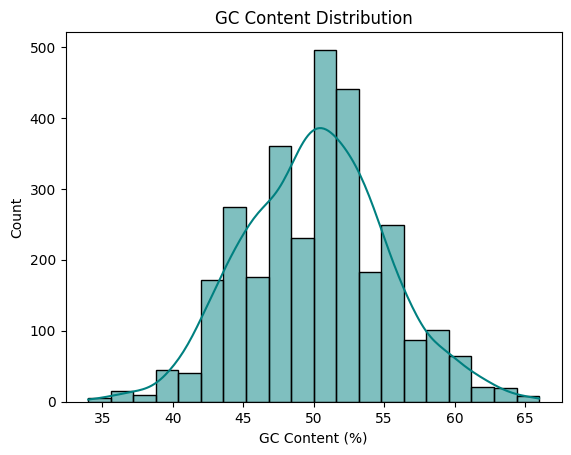

In [12]:
sns.histplot(df['GC_Content'], kde=True, bins=20, color='teal')
plt.title("GC Content Distribution")
plt.xlabel("GC Content (%)")
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


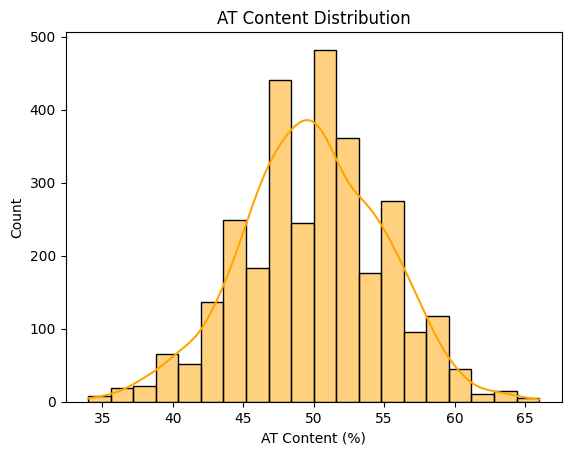

In [13]:
sns.histplot(df['AT_Content'], kde=True, bins=20, color='orange')
plt.title("AT Content Distribution")
plt.xlabel("AT Content (%)")
plt.show()


* Distribution : Both have hardly bell-shape distribution. Both peak around 50%
* Biological Insight : this dataset curated for modeling balance. Less likely to have strong GC/AT bias that could “give away” one class/species (e.g., some viruses are GC-poor—this is controlled here).
* good sign for ml

In [14]:
#Nucleotide Counts
nucleotides = ['Num_A', 'Num_T', 'Num_C', 'Num_G']
df[nucleotides].describe().T

,count,mean,std,min,25%,50%,75%,max
Num_A,3000.0,24.950667,4.317458,11.0,22.0,25.0,28.0,40.0
Num_T,3000.0,24.929333,4.317702,9.0,22.0,25.0,28.0,42.0
Num_C,3000.0,25.004000,4.349056,10.0,22.0,25.0,28.0,42.0
Num_G,3000.0,25.116000,4.329603,12.0,22.0,25.0,28.0,42.0


* Balanced composition
* Variation Exists: Standard deviation is ~4.3 for all, indicating some sequences are A/T- or G/C-rich.
* Quartiles Consistent:25%, 50%, and 75% values are all clustered at 22, 25, 28—this shows most sequences are close to the mean.
* Variability in nucleotide counts (some AT-rich, some GC-rich sequences) could help distinguish between classes (species/types).